In [712]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
%matplotlib inline

# Load datasets

In [713]:
df_weather = pd.read_csv(
    'weather_features.csv', 
    parse_dates=['dt_iso']
)

df_energy = pd.read_csv(
    'energy_dataset.csv', 
    parse_dates=['time']
)

In [714]:
# Convert time to datetime object and set it as index
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

# Convert dt_iso to datetime type, rename it and set it as index
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [715]:
# Convert columns with int64 type values to float64 type
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

# Preprocessing

### Overall Statictics

#### Energy 

In [716]:
df_energy

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
...                                                         ...   
2018-12-31 18:00:00+00:00                                   0.0   
2018-12-31 19:00:00+00:00                                   0.0   
2018-12-31 20:00:00+00:00                                   0.0   
2018-12-31 21:00:00+00:00                                   0.0   
2018-12-31 22:00:00+00:00                                   0.0   

                           generation fossil coal-derived gas  \
time                                                            
2014-12-31 23:00:00+00:00                                 0.0   
2015-01-01 00:00:00+00:00                                 0.0   
2015-01-01 01:00:00+00:00                                 0.0   
2015-01-01 02:00:00+00:00                                 0.0   
2015-01-01 03:00:00+00:00                                 0.0   
...                                                       ...   
2018-12-31 18:00:00+00:00                                 0.0   
2018-12-31 19:00:00+00:00                                 0.0   
2018-12-31 20:00:00+00:00                                 0.0   
2018-12-31 21:00:00+00:00                                 0.0   
2018-12-31 22:00:00+00:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 18:00:00+00:00                 7634.0                       2628.0   
2018-12-31 19:00:00+00:00                 7241.0                       2566.0   
2018-12-31 20:00:00+00:00                 7025.0                       2422.0   
2018-12-31 21:00:00+00:00                 6562.0                       2293.0   
2018-12-31 22:00:00+00:00                 6926.0                       2166.0   

                           generation fossil oil  generation fossil oil shale  \
time                                                                            
2014-12-31 23:00:00+00:00                  162.0                          0.0   
2015-01-01 00:00:00+00:00                  158.0                          0.0   
2015-01-01 01:00:00+00:00                  157.0                          0.0   
2015-01-01 02:00:00+00:00                  160.0                          0.0   
2015-01-01 03:00:00+00:00                  156.0                          0.0   
...                                          ...  

In [717]:
df_energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       generation waste  generation wind offshore  generation wind onshore  \
count      35045.000000                   35046.0             35046.000000   
mean         269.452133                       0.0              5464.479769   
std           50.195536                       0.0              3213.691587   
min            0.000000                       0.0                 0.000000   
25%          240.000000                       0.0              2933.000000   
50%          279.000000                       0.0              4849.000000   
75%          310.000000                       0.0              7398.000000   
max          357.000000                       0.0             17436.000000   

       forecast solar day ahead  forecast wind offshore eday ahead  \
count              35064.000000                                0.0   
mean                1439.066735                                NaN   
std                 1677.703355       

In [718]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil coal-derived gas           35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation fossil oil shale                  35046 non-null  float64
 7   generation fossil peat                       35046 non-null  float64
 8   generation geothermal                        35046 non-null  float64
 9   generation hydro pumped s

#### Weather

In [719]:
df_weather

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
...                             ...      ...       ...       ...       ...   
2018-12-31 18:00:00+00:00   Seville  287.760   287.150   288.150    1028.0   
2018-12-31 19:00:00+00:00   Seville  285.760   285.150   286.150    1029.0   
2018-12-31 20:00:00+00:00   Seville  285.150   285.150   285.150    1028.0   
2018-12-31 21:00:00+00:00   Seville  284.150   284.150   284.150    1029.0   
2018-12-31 22:00:00+00:00   Seville  283.970   282.150   285.150    1029.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00      77.0         1.0      62.0      0.0      0.0   
2015-01-01 00:00:00+00:00      77.0         1.0      62.0      0.0      0.0   
2015-01-01 01:00:00+00:00      78.0         0.0      23.0      0.0      0.0   
2015-01-01 02:00:00+00:00      78.0         0.0      23.0      0.0      0.0   
2015-01-01 03:00:00+00:00      78.0         0.0      23.0      0.0      0.0   
...                             ...         ...       ...      ...      ...   
2018-12-31 18:00:00+00:00      54.0         3.0      30.0      0.0      0.0   
2018-12-31 19:00:00+00:00      62.0         3.0      30.0      0.0      0.0   
2018-12-31 20:00:00+00:00      58.0         4.0      50.0      0.0      0.0   
2018-12-31 21:00:00+00:00      57.0         4.0      60.0      0.0      0.0   
2018-12-31 22:00:00+00:00      70.0         3.0      50.0      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2014-12-31 23:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 00:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 01:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 02:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 03:00:00+00:00      0.0         0.0       800.0        clear   
...                            ...         ...         ...          ...   
2018-12-31 18:00:00+00:00      0.0         0.0       800.0        clear   
2018-12-31 19:00:00+00:00      0.0         0.0       800.0        clear   
2018-12-31 20:00:00+00:00      0.0         0.0       800.0        clear   
2018-12-31 21:00:00+00:00      0.0         0.0       800.0        clear   
2018-12-31 22:00:00+00:00      0.0         0.0       800.0        clear   

                          weather_description weather_icon  
time                                                        
2014-12-31 23:00:00+00:00        sky is clear          01n  
2015-01-01 00:00:00+00:00        sky is clear          01n  
2015-01-01 01:00:00+00:00        sky is clear          01n  
2015-01-01 02:00:00+00:00        sky is clear          01n  
2015-01-01 03:00:00+00:00        sky is clear          01n  
...                                       ...          ...  
2018-12-31 18:00:00+00:00        sky is clear          01n  
2018-12-31 19:00:00+00:00        sky is clear          01n  
2018-12-31 20:00:00+00:00        sky is clear          01n  
2018-12-31 21:00:00+00:00        sky is clear          01n  
2018-12-31 22:00:00+00:00        sky is clear          01n  

[178396 rows x 16 columns]

In [720]:
df_weather.describe()

temp       temp_min       temp_max      pressure  \
count  178396.000000  178396.000000  178396.000000  1.783960e+05   
mean      289.618605     288.330442     291.091267  1.069261e+03   
std         8.026199       7.955491       8.612454  5.969632e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.483602     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730125     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity    wind_speed       wind_deg        rain_1h  \
count  178396.000000  178396.00000  178396.000000  178396.000000   
mean       68.423457       2.47056     166.591190       0.075492   
std        21.902888       2.09591     116.611927       0.398847   
min         0.000000       0.00000       0.000000       0.000000   
25%        53.000000       1.00000      55.000000       0.000000   
50%        72.000000       2.00000     177.000000       0.000000   
75%        87.000000       4.00000     270.000000       0.000000   
max       100.000000     133.00000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178396.000000  178396.000000  178396.000000  178396.000000  
mean        0.000380       0.004763      25.073292     759.831902  
std         0.007288       0.222604      30.774129     108.733223  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

In [721]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   city_name            178396 non-null  object 
 1   temp                 178396 non-null  float64
 2   temp_min             178396 non-null  float64
 3   temp_max             178396 non-null  float64
 4   pressure             178396 non-null  float64
 5   humidity             178396 non-null  float64
 6   wind_speed           178396 non-null  float64
 7   wind_deg             178396 non-null  float64
 8   rain_1h              178396 non-null  float64
 9   rain_3h              178396 non-null  float64
 10  snow_3h              178396 non-null  float64
 11  clouds_all           178396 non-null  float64
 12  weather_id           178396 non-null  float64
 13  weather_main         178396 non-null  object 
 14  weather_description  1

### Missing values interpolation (zero and NaN), and  duplicate  removal

#### Energy 

In [722]:
# Drop features with only zero or NaN 
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [723]:
# Find the number of NaNs/0 in each column
print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))
df_energy.isnull().sum(axis=0)

There are 292 missing values or NaNs in df_energy.


generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Interpretation: Almost all features have a few missing values. 

In [724]:
# Find ways to interpolate. 
#Firstly, let's see if the missing values are at the same time. 
df_energy[df_energy.isnull().any(axis=1)].tail()

generation biomass  \
time                                            
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2016-11-23 03:00:00+00:00                                 900.0   
2017-11-14 11:00:00+00:00                                   0.0   
2017-11-14 18:00:00+00:00                                   0.0   
2018-06-11 16:00:00+00:00                                 506.0   
2018-07-11 07:00:00+00:00                                   NaN   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2016-11-23 03:00:00+00:00                 4838.0                       4547.0   
2017-11-14 11:00:00+00:00                10064.0                          0.0   
2017-11-14 18:00:00+00:00                12336.0                          0.0   
2018-06-11 16:00:00+00:00                 7538.0                       5360.0   
2018-07-11 07:00:00+00:00                    NaN                          NaN   

                           generation fossil oil  \
time                                               
2016-11-23 03:00:00+00:00                  269.0   
2017-11-14 11:00:00+00:00                    0.0   
2017-11-14 18:00:00+00:00                    0.0   
2018-06-11 16:00:00+00:00                  300.0   
2018-07-11 07:00:00+00:00                    NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2016-11-23 03:00:00+00:00                                       1413.0   
2017-11-14 11:00:00+00:00                                          0.0   
2017-11-14 18:00:00+00:00                                          0.0   
2018-06-11 16:00:00+00:00                                          1.0   
2018-07-11 07:00:00+00:00                                          NaN   

                           generation hydro run-of-river and poundage  \
time                                                                    
2016-11-23 03:00:00+00:00                                       795.0   
2017-11-14 11:00:00+00:00                                         0.0   
2017-11-14 18:00:00+00:00                                         0.0   
2018-06-11 16:00:00+00:00                                      1134.0   
2018-07-11 07:00:00+00:00                                         NaN   

                           generation hydro water reservoir  \
time                                                          
2016-11-23 03:00:00+00:00                             435.0   
2017-11-14 11:00:00+00:00                               0.0   
2017-11-14 18:00:00+00:00                               0.0   
2018-06-11 16:00:00+00:00                            4258.0   
2018-07-11 07:00:00+00:00                               NaN   

                           generation nuclear  generation other  \
time                                                              
2016-11-23 03:00:00+00:00              5040.0              60.0   
2017-11-14 11:00:00+00:00                 0.0               0.0   
2017-11-14 18:00:00+00:00                 0.0               0.0   
2018-06-11 16:00:00+00:00              5856.0              52.0   
2018-07-11 07:00:00+00:00                 NaN               NaN   

                           generation other renewable  generation solar  \
time                                                                      
2016-11-23 03:00:00+00:00                        85.0              15.0   
2017-11-14 11:00:00+00:00                         0.0               0.0   
2017-11-14 18:00:00+00:00            

Interpretation: no opportunity to deduct variables from each other

In [725]:
# Linear interpolation
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
# Check if it worked well
df_energy.isnull().sum(axis=0)

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

#### Weather

In [726]:
print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))
df_weather.isnull().sum(axis=0)

There are 0 missing values or NaNs in df_weather.


city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [727]:
# Drop columns with qualitative weather information as they are useless for the implemented algorithm
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

### Duplicate removal

#### Energy

In [728]:
temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 0 duplicate rows in df_energy based on all columns.


#### Weather

In [729]:
temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 13038 duplicate rows in df_weather based on all columns.


In [730]:
# Drop duplicate rows in df_weather
df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

### Outlier removeal

#### Energy

array([[<AxesSubplot:title={'center':'generation biomass'}>,
        <AxesSubplot:title={'center':'generation fossil brown coal/lignite'}>,
        <AxesSubplot:title={'center':'generation fossil gas'}>,
        <AxesSubplot:title={'center':'generation fossil hard coal'}>],
       [<AxesSubplot:title={'center':'generation fossil oil'}>,
        <AxesSubplot:title={'center':'generation hydro pumped storage consumption'}>,
        <AxesSubplot:title={'center':'generation hydro run-of-river and poundage'}>,
        <AxesSubplot:title={'center':'generation hydro water reservoir'}>],
       [<AxesSubplot:title={'center':'generation nuclear'}>,
        <AxesSubplot:title={'center':'generation other'}>,
        <AxesSubplot:title={'center':'generation other renewable'}>,
        <AxesSubplot:title={'center':'generation solar'}>],
       [<AxesSubplot:title={'center':'generation waste'}>,
        <AxesSubplot:title={'center':'generation wind onshore'}>,
        <AxesSubplot:title={'center':'to

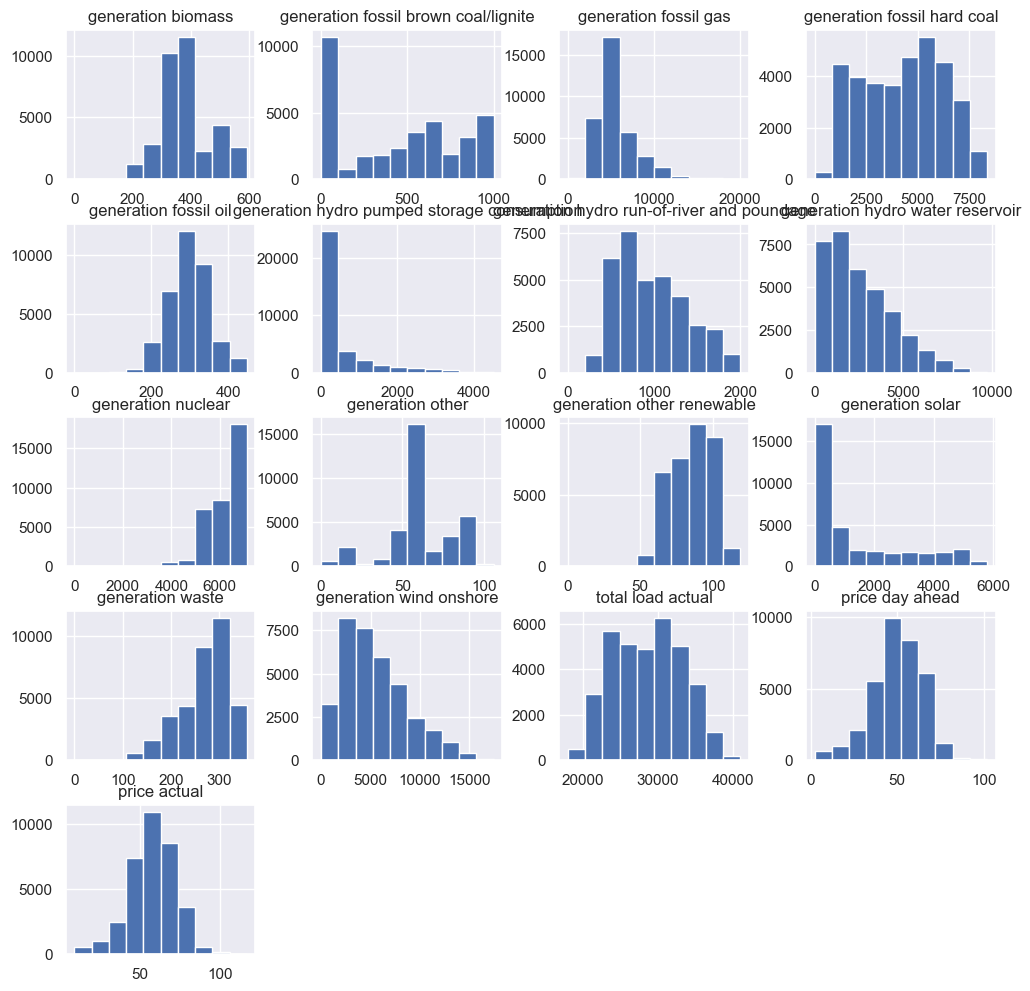

In [731]:
# Check outliers
df_energy.hist(grid=True, figsize=(12,12))

Interpretation: no noticable outliers

#### Weather

array([[<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'temp_min'}>,
        <AxesSubplot:title={'center':'temp_max'}>],
       [<AxesSubplot:title={'center':'pressure'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'wind_speed'}>],
       [<AxesSubplot:title={'center':'wind_deg'}>,
        <AxesSubplot:title={'center':'rain_1h'}>,
        <AxesSubplot:title={'center':'rain_3h'}>],
       [<AxesSubplot:title={'center':'snow_3h'}>,
        <AxesSubplot:title={'center':'clouds_all'}>, <AxesSubplot:>]],
      dtype=object)

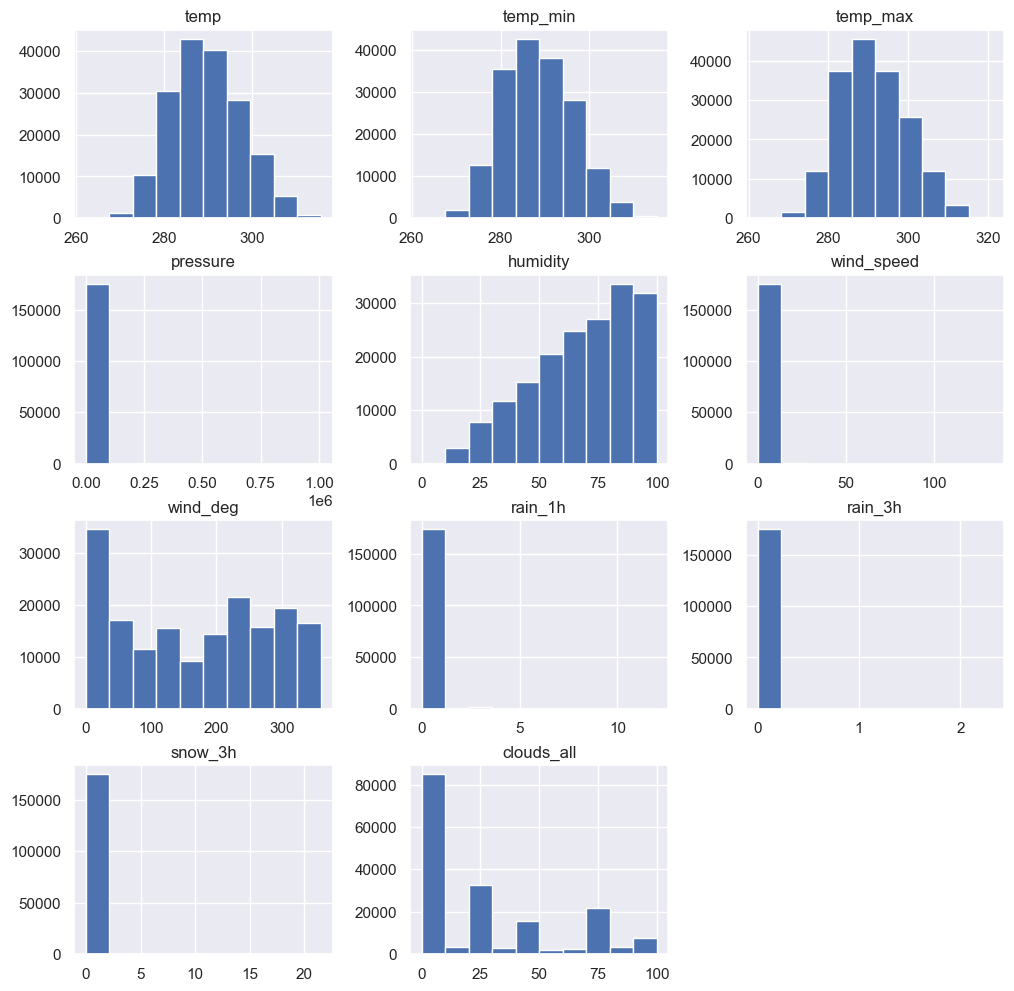

In [732]:
df_weather.hist(grid=True, figsize=(12,12))

Interpretation: the following features have outliers : pressure, wind_speed, rain_1h, rain_3h, and snow 3h.

###### 'pressure' outliers

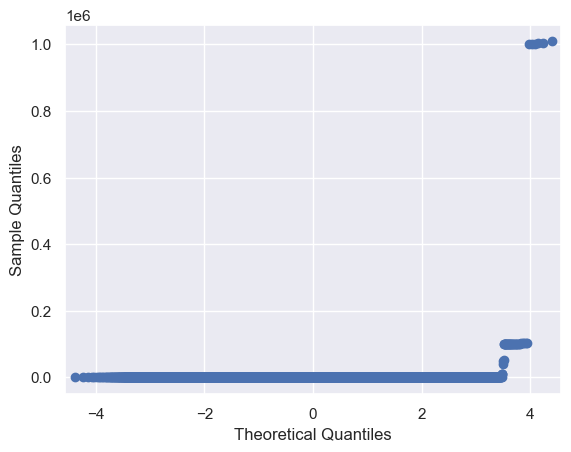

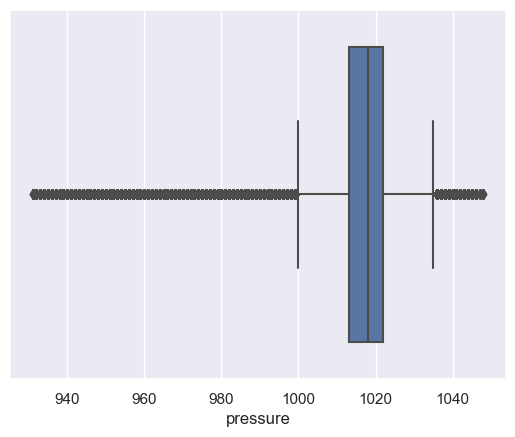

In [733]:
sm.qqplot(df_weather['pressure'])
py.show()

# Replace outliers with NaNs
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

# Check for outliers again
sns.boxplot(x=df_weather['pressure'])
plt.show()

###### 'wind_speed' outliers

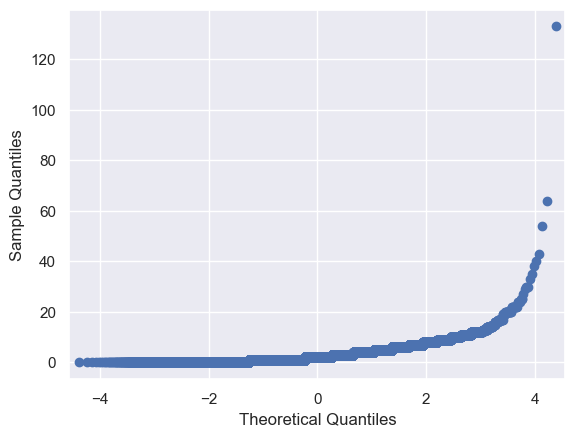

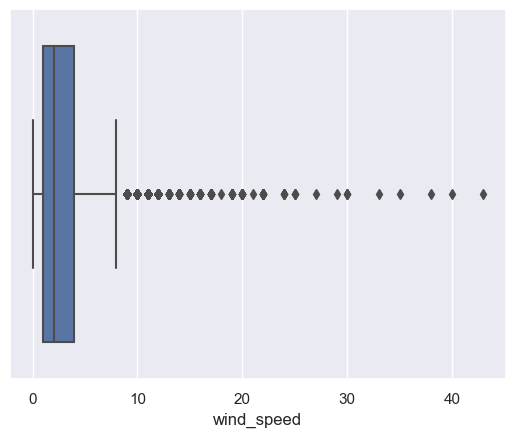

In [734]:
sm.qqplot(df_weather['wind_speed'])
py.show()

# Replace outliers with NaNs
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

# Check for outliers again
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

###### 'rain_1h' outliers

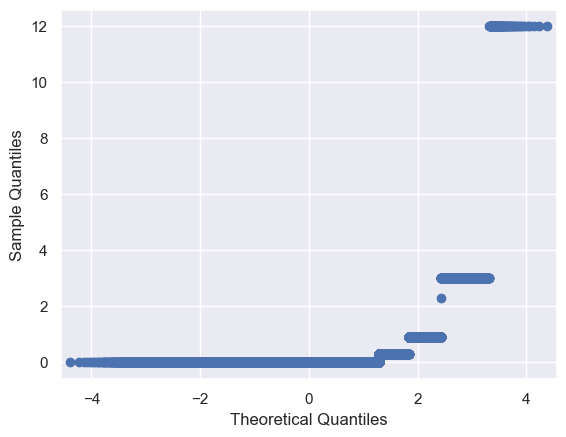

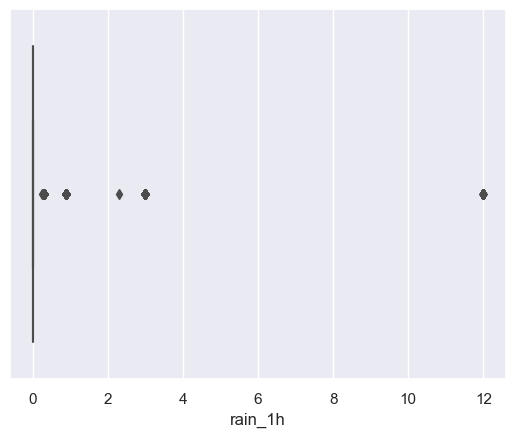

In [735]:
sm.qqplot(df_weather['rain_1h'])
py.show()

# Check for outliers again
sns.boxplot(x=df_weather['rain_1h'])
plt.show()

Interpretation: no outliers as zero value otherwise

###### 'rain_3h' outliers

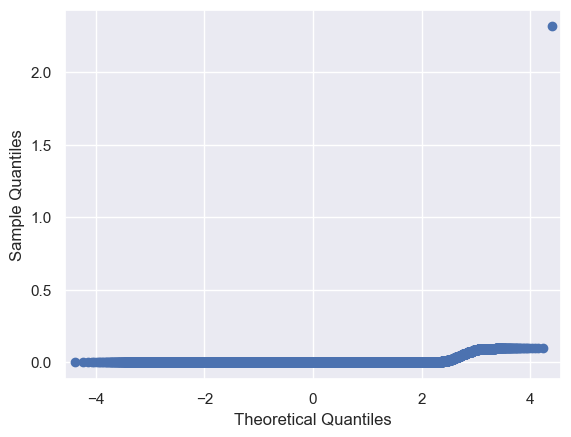

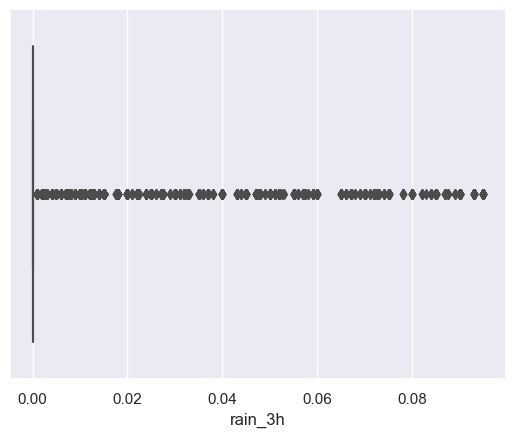

In [736]:
sm.qqplot(df_weather['rain_3h'])
py.show()

# Replace outliers with NaNs
df_weather.loc[df_weather.rain_3h > 0.095, 'rain_3h'] = np.nan
#df_weather.loc[df_weather.rain_3h < 0.001, 'rain_3h'] = np.nan

# Check for outliers again
sns.boxplot(x=df_weather['rain_3h'])
plt.show()

###### 'snow_3h' outliers

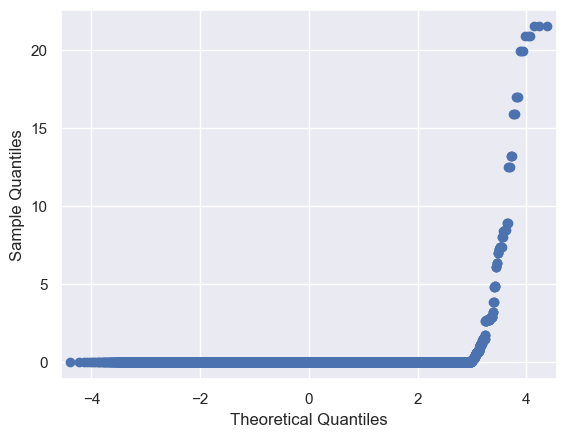

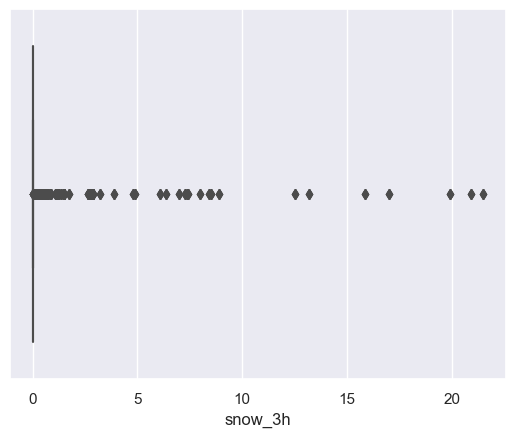

In [737]:
sm.qqplot(df_weather['snow_3h'])
plt.show()
# Check for outliers again
sns.boxplot(x=df_weather['snow_3h'])
plt.show()

In [738]:
# Replace NaN (from outliers) by interpolated values
df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

### Merge two datasets 

In [739]:
# Split the df_weather into 5 dataframes (one for each city)
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [740]:
# Merge all dataframes into the final dataframe
df_final = df_energy
for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)  

# Analysis of time series properties

### Insight from visualization

In [741]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/var/folders/tx/cc_92qnj2x79v_j0dnr67jg40000gn/T/ipykernel_4902/1031602474.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


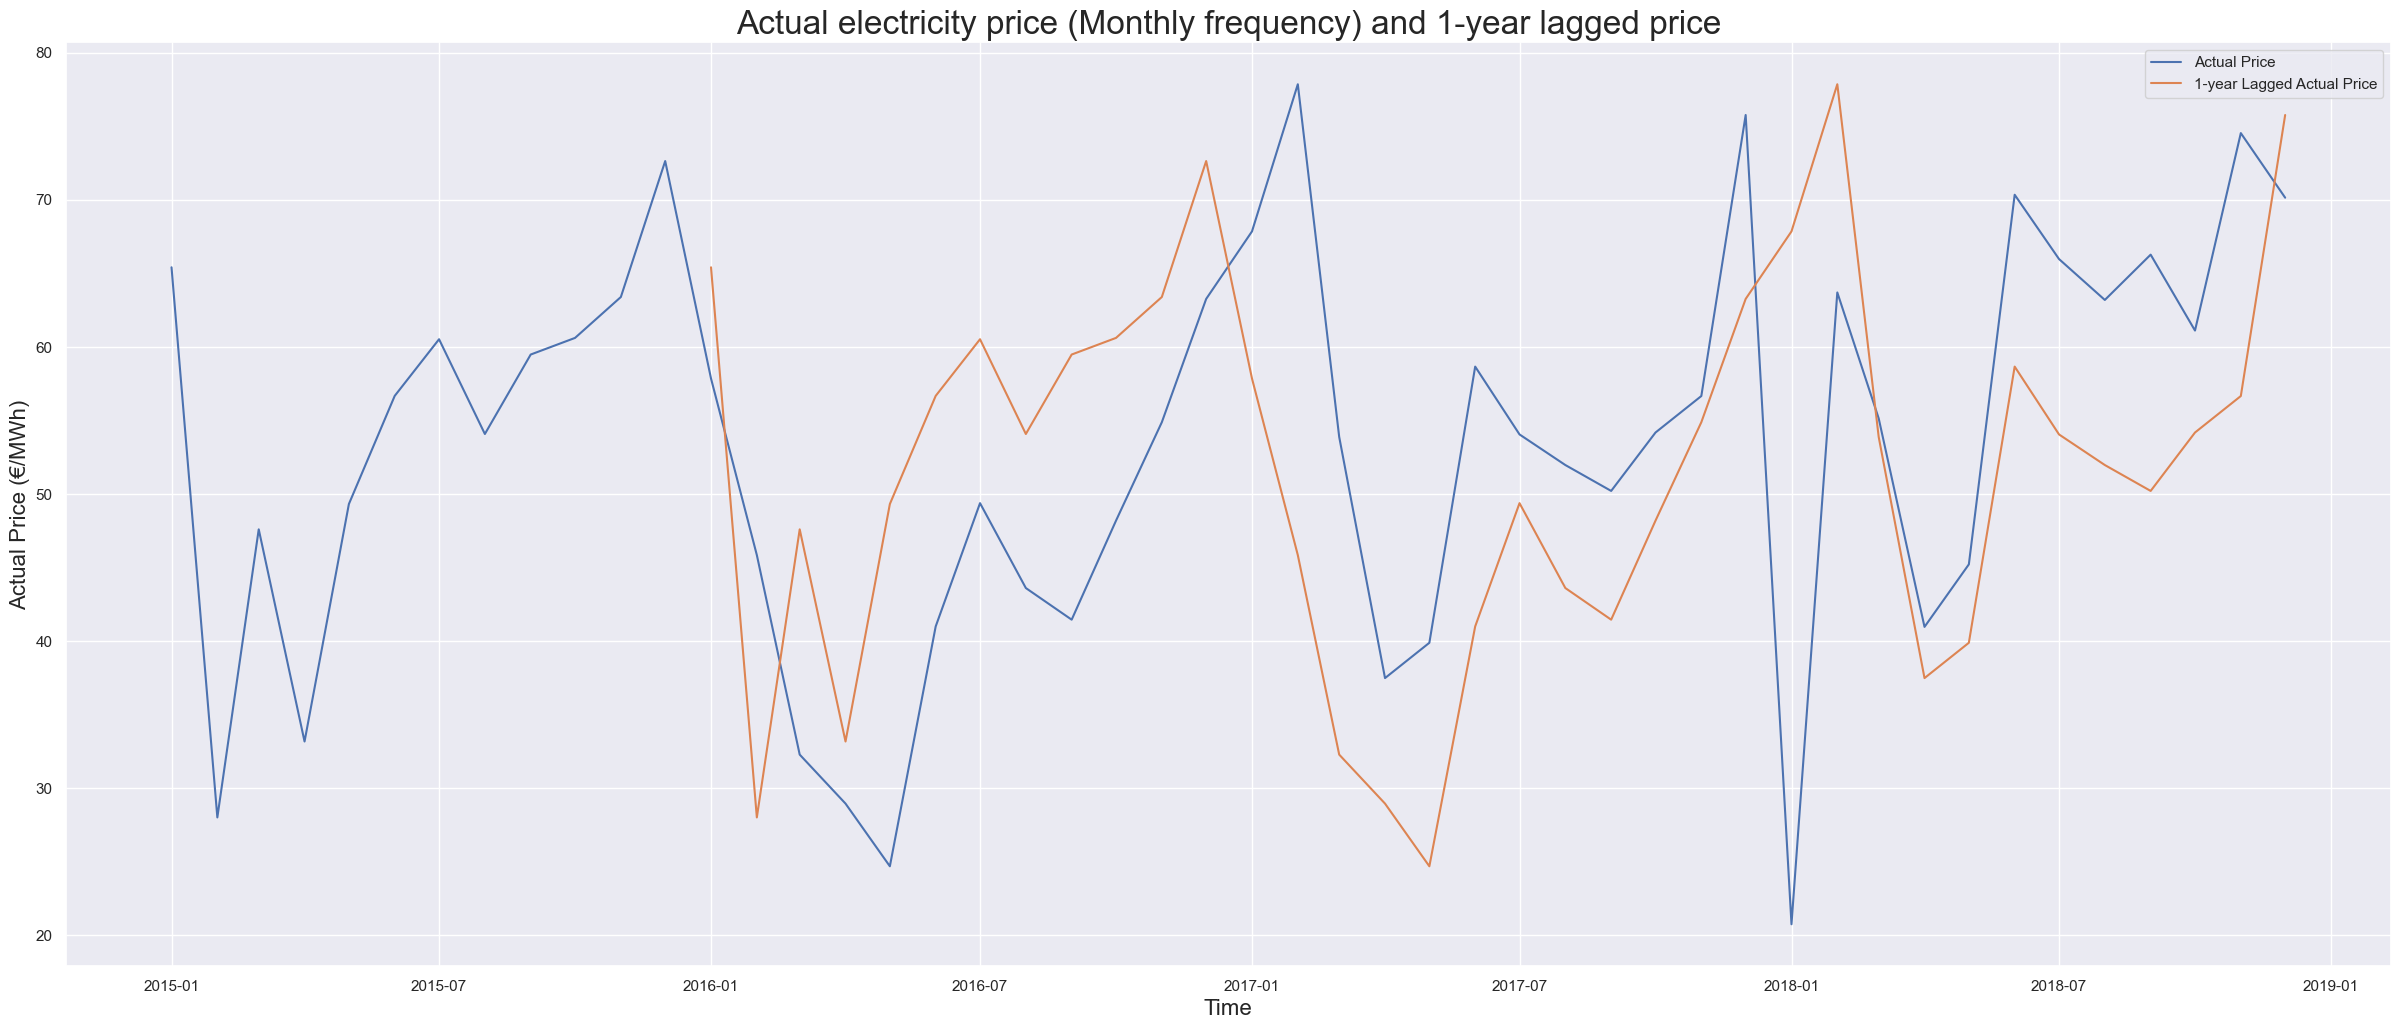

In [742]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

Interpretation: The figure shows that there is a seasonal patterns at the monthly scale. 

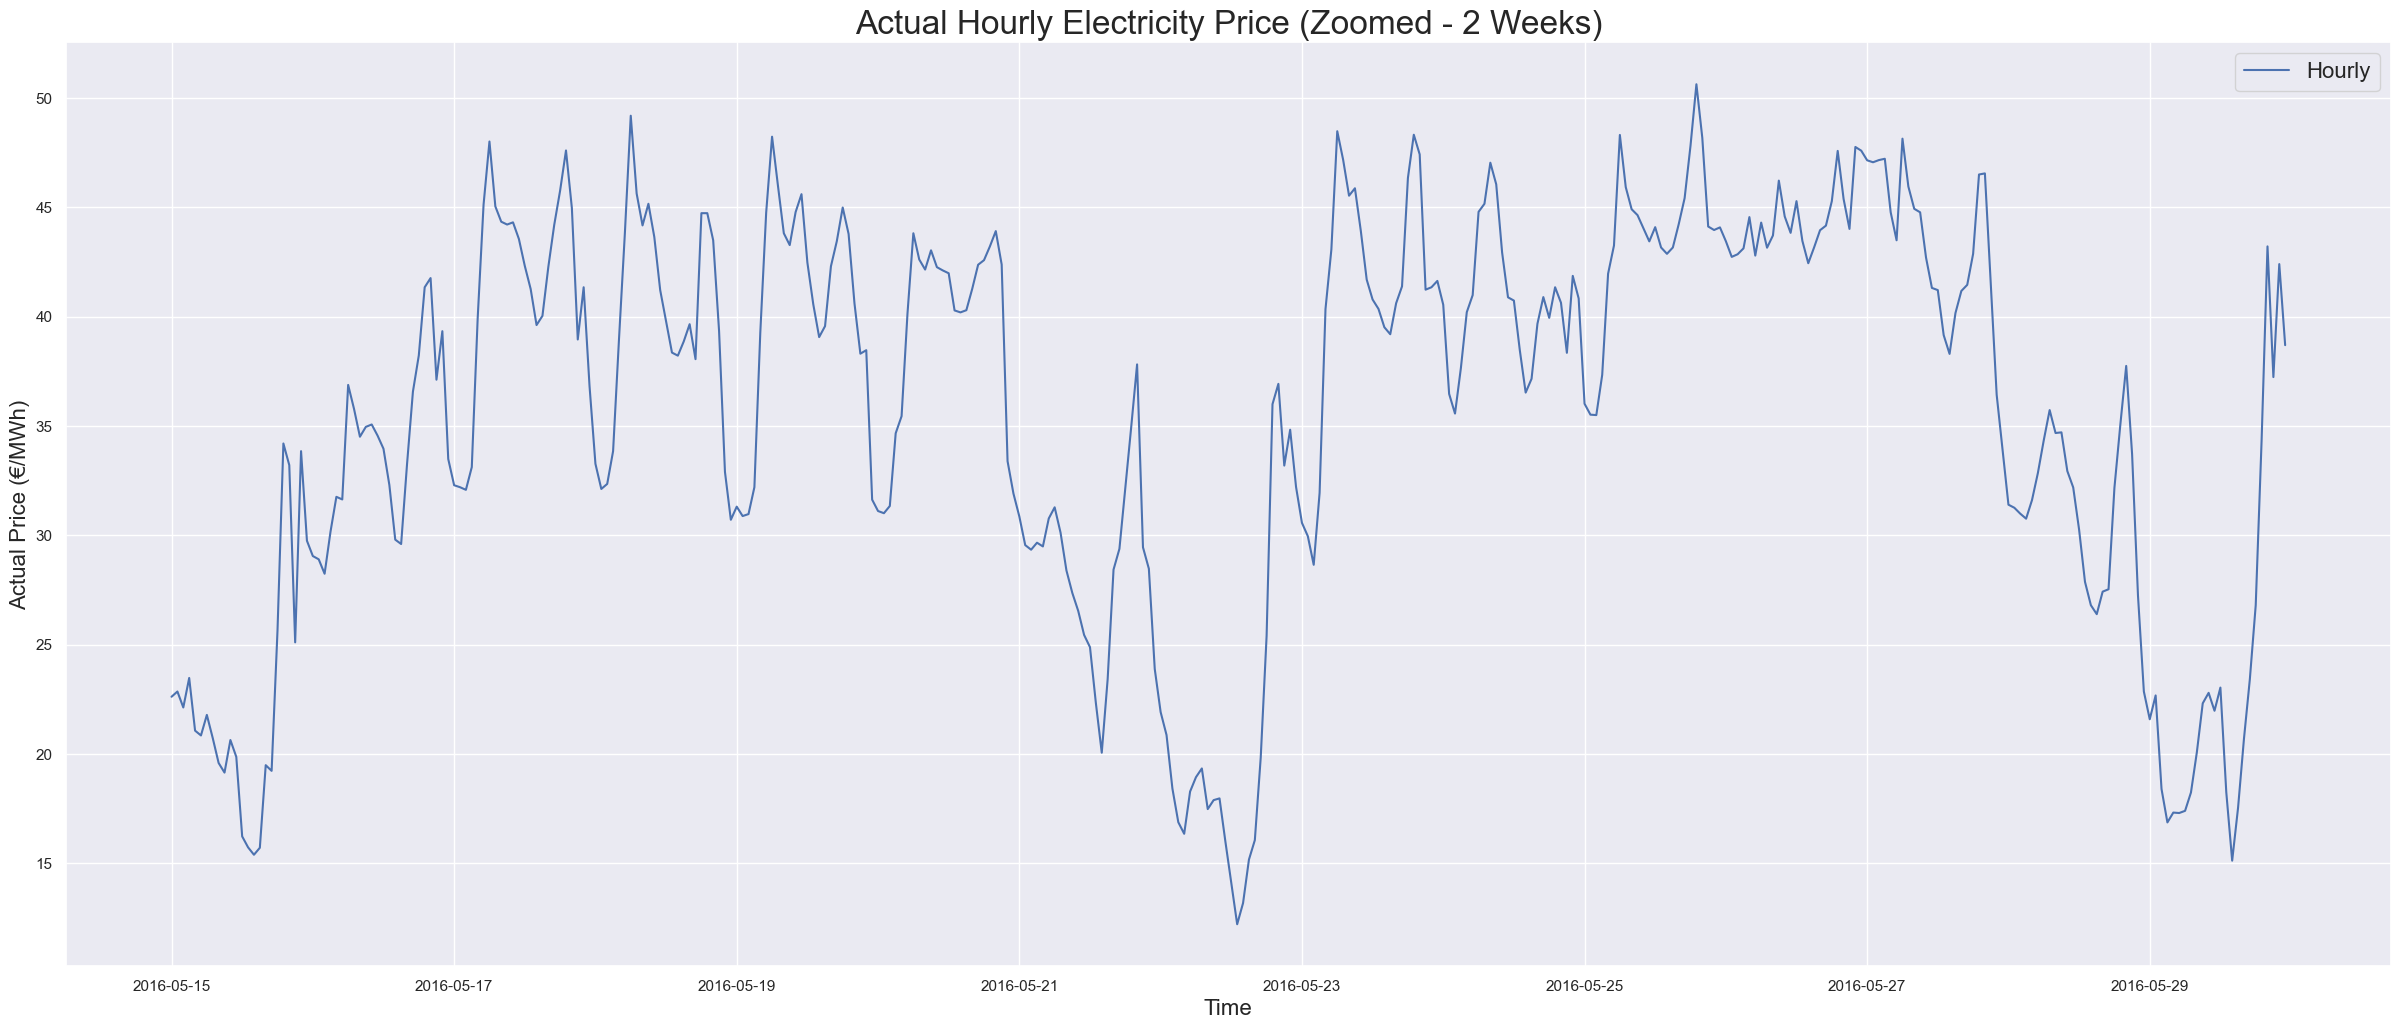

In [743]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

Interpretation: The figure above shows a periodicity at the weekly scale. Especially, it shows that the prices are lower during weekends.

### Auto-correlation and partial auto-correlation

/Users/DEGUITAUT/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


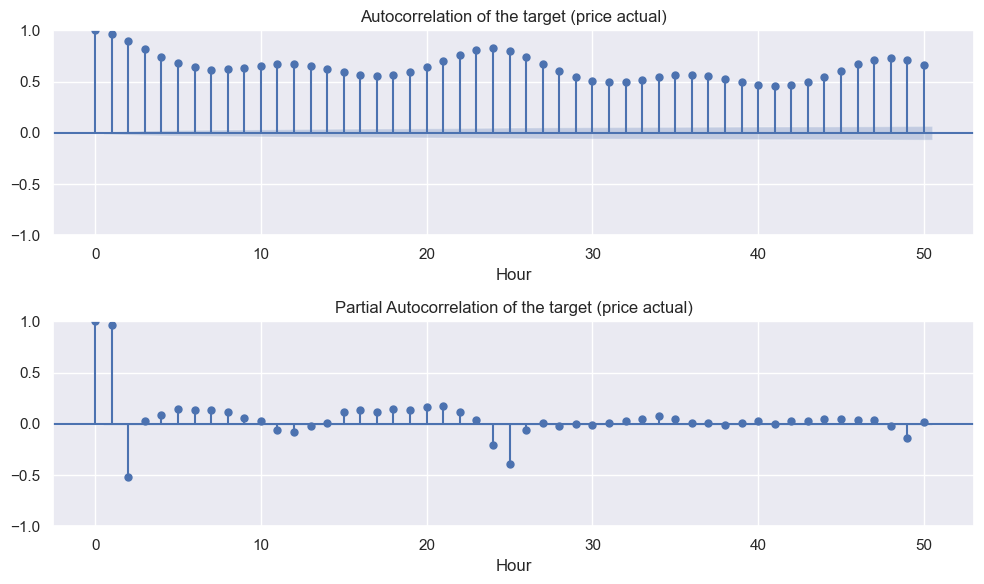

In [744]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation of the target (price actual)')
ax1.set_xlabel('Hour')
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation of the target (price actual)')
ax2.set_xlabel('Hour')
plt.tight_layout()
plt.show()

Interpretation: The partial autocorrelation shows that there are a strong relationship between the price at a given hour, t, and the prices at (t-1), (t-2), (t-24) and (t-25).

### Correlations between features

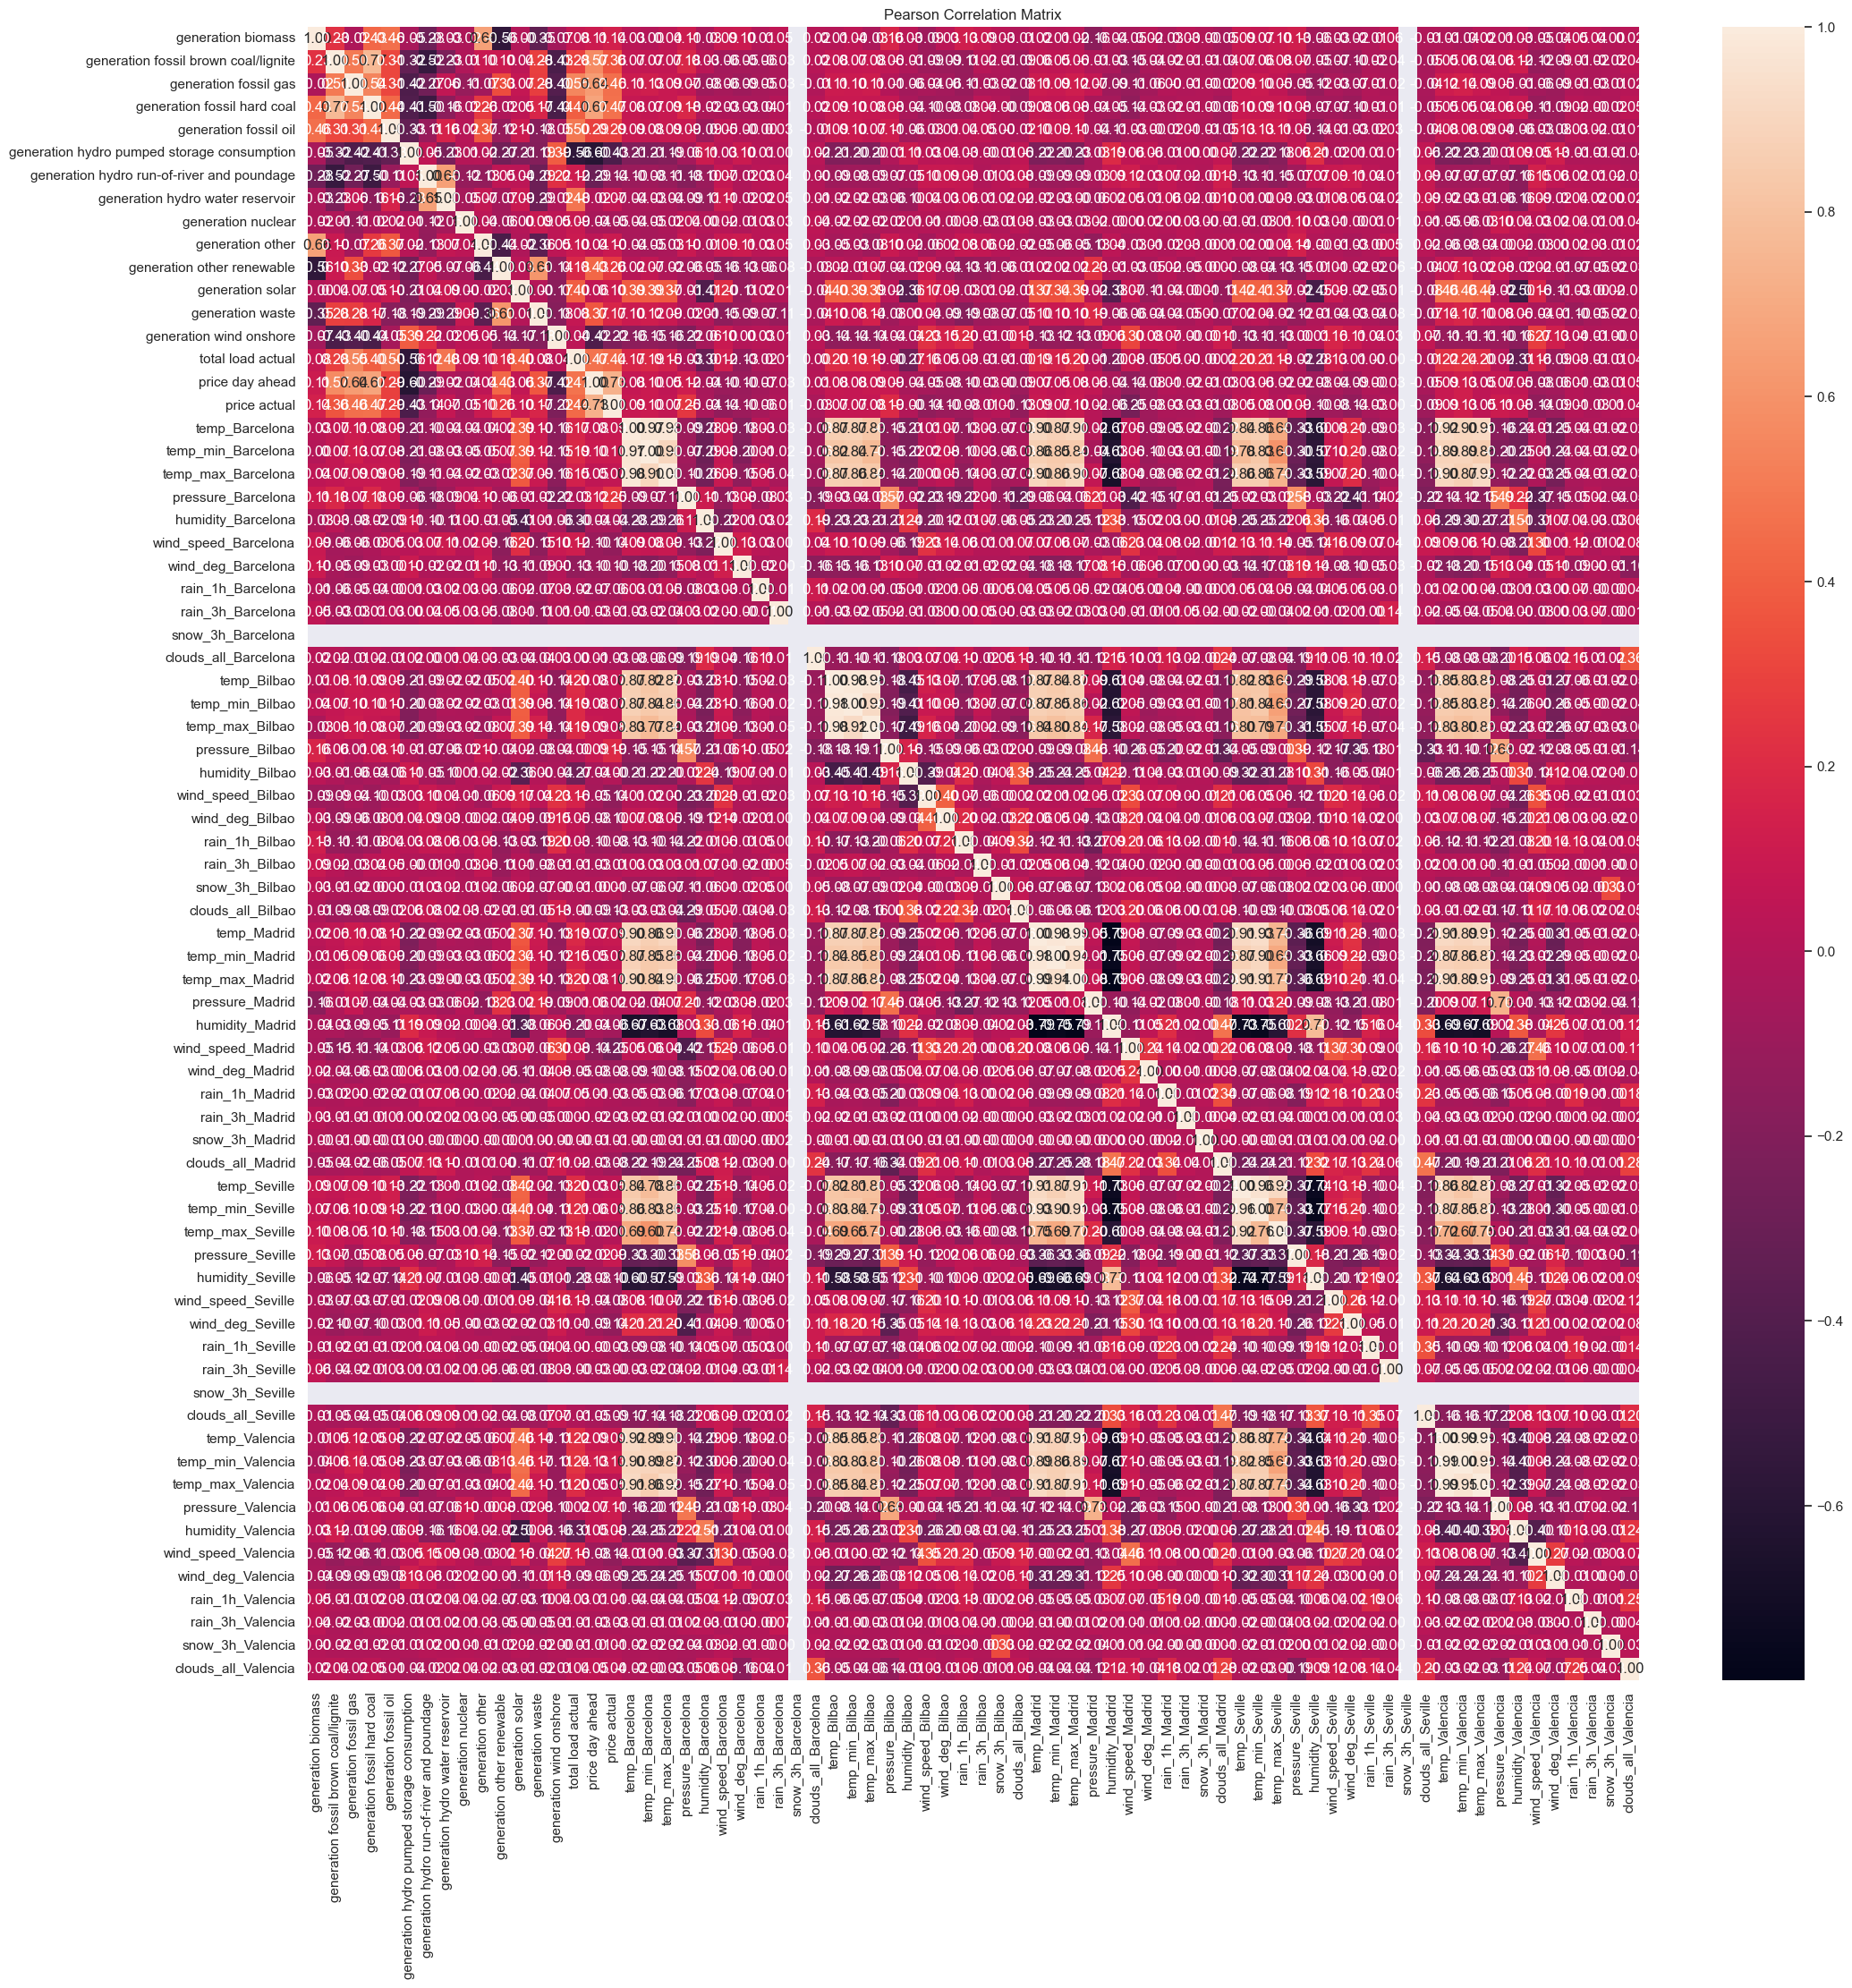

In [745]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

### Stationarity test

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [746]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/Users/DEGUITAUT/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Interpretation: We cannot reject the null hypothesis with a significant level 1%, which means the the time series is stationary. 

# Feature engineering (same as the Kaggle winnr in order to be able to compare the performance of the prediction algorithms)

In [747]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month
    
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0
                
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0
        
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

# Generate 'temp_weighted' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted
    
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

# Feature selection